<a href="https://colab.research.google.com/github/isaacmg/task-vt/blob/re_model_revised/drug_treatment_extraction/notebooks/%20training_data_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating Training Data for Relation Extraction
This is a brief notebook to show how data training/test data was created for the relation extraction task. The goal of this pre-processing is to put data in a format roughly analogous to the GAD training data found for BioBERT. In the GAD data we have TSV sperated file with a sentence, a gene_mask a diesase_mask, and a binary label (0,1). 
```
Our findings indicate that the @GENE$ -141C Ins allele and the 5-HTTLPR S allele are genetic risk factors for alcoholism in Mexican-Americans, and that smoking modulates the association between genetic risk factors and @DISEASE$.	1

Our matched case-control and family study indicate that Cx50, but not @GENE$, may play a role in the genetic susceptibility to @DISEASE$.	0
```

In [0]:
!gsutil cp gs://coronaviruspublicdata/snapshot_re_4_12_2020/drugvisdata.xlsx	drugvis.xlsx
!gsutil cp gs://coronaviruspublicdata/snapshot_re_4_12_2020/FakeSentences_For_Aradana.csv	fakes.csv
!gsutil cp gs://coronaviruspublicdata/snapshot_re_4_12_2020/export.csv export.csv


Copying gs://coronaviruspublicdata/snapshot_re_4_12_2020/drugvisdata.xlsx...
- [1 files][122.9 KiB/122.9 KiB]                                                
Operation completed over 1 objects/122.9 KiB.                                    
Copying gs://coronaviruspublicdata/snapshot_re_4_12_2020/FakeSentences_For_Aradana.csv...
- [1 files][ 88.9 MiB/ 88.9 MiB]                                                
Operation completed over 1 objects/88.9 MiB.                                     
Copying gs://coronaviruspublicdata/snapshot_re_4_12_2020/export.csv...
/ [1 files][  6.5 MiB/  6.5 MiB]                                                
Operation completed over 1 objects/6.5 MiB.                                      


In [0]:
import pandas as pd
positive_df = pd.read_csv("export.csv").drop_duplicates(subset='sentence')
negatives_df = pd.read_csv("fakes.csv").drop_duplicates(subset='new_sentence')

In [0]:
len(positive_df)

21296

In [0]:
len(negatives_df)

194674

In [0]:
positive_df.head()

,drug,disease,sentence,score
0,Tamoxifen,breast cancer,Tamoxifen for the treatment and prevention of ...,1.0
1,methotrexate,rheumatoid arthritis,-LSB- Use of methotrexate in the treatment of ...,1.0
2,TAM,breast cancer,The mutations of OATP1B1 388GG and 521CC inhib...,1.0
3,STI571,chronic myelogenous leukemia,OBJECTIVE : The aim of this study was the prec...,1.0
4,Sorafenib,HCC,Sorafenib plus cisplatin and gemcitabine in th...,1.0


In [0]:
negatives_df.head()

,Unnamed: 0,sha,blockid,word_drug,sec,orig_sentence,new_sentence,inserted_word
0,0,c86aeb45062aa6a85a08a2fc1e3806bd57add39b,0,cholesterol,body,"191-192, 192t, 193t clinical signs of, 193 di...","191-192, 192t, 193t clinical signs of, 193 di...",improve
1,1,922e59f9a0ff746cf0d43e10989359ae9764a213,52,cidofovir,body,voraus! Antibiotikaempfindlichkeit HHV-6 ist g...,voraus! Antibiotikaempfindlichkeit HHV-6 reduc...,reduce
2,2,922e59f9a0ff746cf0d43e10989359ae9764a213,52,foscarnet,body,voraus! Antibiotikaempfindlichkeit HHV-6 ist g...,voraus! Antibiotikaempfindlichkeit HHV-6 ist g...,suppress
3,3,922e59f9a0ff746cf0d43e10989359ae9764a213,52,ganciclovir,body,voraus! Antibiotikaempfindlichkeit HHV-6 ist g...,voraus! Antibiotikaempfindlichkeit HHV-6 ist g...,therapeutic
4,4,29e127bd725d589be1458079521381080cfc2e90,15,air,body,""" Significantly different on comparison of ozo...",""" suppression Significantly different on compa...",suppression


**Assumption 1** 

All data in the positive_df is actually positive. The positive_df here is a set of sentences that comes from this resource called [GNBR](https://zenodo.org/record/1134693#.Xo7aktNKjys), which is based on these references: 

1. https://www.ncbi.nlm.nih.gov/pubmed/29490008

2. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004216). 

In [0]:
positive_df['label'] = 1

**Assumption 2**

All data in the negative_df is actually negative. Not sure where these sentences came from at the moment. But was assured that they should work.

In [0]:
negatives_df['label'] = 0
negatives_df = negatives_df.rename(columns={'new_sentence': 'sentence', "word_drug":'drug', 'inserted_word':"treatment"})

**Combining Positive and Negative Examples**

As there is a class imbalance 194,765 vs 30,000 we probably don't want to merge all negative examples together. Instead we will use 40k negative examples and all 30k positive ones.

In [107]:
frames = [positive_df, negatives_df.sample(40000)]
combined_traindf = pd.concat(frames)
combined_traindf.head()

,drug,disease,sentence,score,label,Unnamed: 0,sha,blockid,sec,orig_sentence,treatment
0,Tamoxifen,breast cancer,Tamoxifen for the treatment and prevention of ...,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,methotrexate,rheumatoid arthritis,-LSB- Use of methotrexate in the treatment of ...,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,TAM,breast cancer,The mutations of OATP1B1 388GG and 521CC inhib...,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,STI571,chronic myelogenous leukemia,OBJECTIVE : The aim of this study was the prec...,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,Sorafenib,HCC,Sorafenib plus cisplatin and gemcitabine in th...,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN


**Using no masking**

While GAD does use masking we decided to first test whether masking is really necessary. 

In [0]:
export_df = combined_traindf[['sentence', 'label']]
# We want to shuffle positive and negative examples.
export_df = export_df.sample(frac=1)

In [115]:
print(len(export_df))
export_df[:59000].to_csv('no_mask_train_data.tsv', index=False, header=False, sep='\t')
export_df[59000:60000].to_csv('no_mask_dev_data.tsv', index=False, header=False, sep='\t')
export_df[60000:].to_csv('no_mask_dev_eval.tsv', index=False, header=True, sep='\t')
export_df.head(20)

61296


,sentence,label
121658,HCV genotype was determined by hybridization o...,0
22523,The introduction of imatinib_mesylate has chan...,1
23245,The standard therapy for unresectable HCC with...,1
12517,"After the final ethanol wash, add cure 100% et...",0
154939,Washed samples were suppression negatively sta...,0
7449,Methods : We performed a French multicenter re...,1
114198,Quantitative viral culture was difficult to pe...,0
29968,The routine use of 5 years of adjuvant tamoxif...,1
37966,"Resistant strains (n = 80): oxacillin 45%, gen...",0
136907,"The increase in the blood urea nitrogen level,...",0


In [116]:
from google.colab import auth
auth.authenticate_user()
!gsutil cp no_mask_train_data.tsv gs://coronaviruspublicdata/snapshot_re_4_12_2020/no_mask_train.tsv 
!gsutil cp no_mask_dev_data.tsv gs://coronaviruspublicdata/snapshot_re_4_12_2020/no_mask_dev.tsv
!gsutil cp no_mask_dev_eval.tsv gs://coronaviruspublicdata/snapshot_re_4_12_2020/no_mask_eval2.tsv                       

Copying file://no_mask_train_data.tsv [Content-Type=text/tab-separated-values]...
-
Operation completed over 1 objects/11.1 MiB.                                     
Copying file://no_mask_dev_data.tsv [Content-Type=text/tab-separated-values]...
-
Operation completed over 1 objects/191.6 KiB.                                    
Copying file://no_mask_dev_eval.tsv [Content-Type=text/tab-separated-values]...
-
Operation completed over 1 objects/250.0 KiB.                                    


**Adding Evaluation Data**

In [0]:
eval_data_df = pd.read_excel("drugvis.xlsx", sheet_name = 0).drop_duplicates(subset='sentence')
eval_data_df['label'] = eval_data_df['Target']
eval_data_df.sample(frac=1)
train_eval = eval_data_df[:200]
dev_eval = eval_data_df[200:210]
test_eval = eval_data_df[210:]

In [122]:
#eval_data_df[['sentence', 'label']].to_csv('eval_data.tsv', index=False, header=True, sep='\t')
#!gsutil cp eval_data.tsv gs://coronaviruspublicdata/snapshot_re_4_12_2020/eval_data.tsv
# Data for here 
train_eval[['sentence', 'label']].to_csv('drug_train_data.tsv', index=False, header=False, sep='\t')
dev_eval[['sentence', 'label']].to_csv('drug_dev_data.tsv', index=False, header=False, sep='\t')
test_eval[['sentence', 'label']].to_csv('drug_test_data.tsv', index=False, header=True, sep='\t')
!gsutil cp drug_train_data.tsv gs://coronaviruspublicdata/snapshot_re_4_12_2020/drug_train_data.tsv
!gsutil cp drug_dev_data.tsv gs://coronaviruspublicdata/snapshot_re_4_12_2020/drug_dev_data.tsv
!gsutil cp drug_test_data.tsv gs://coronaviruspublicdata/snapshot_re_4_12_2020/drug_test_data.tsv

Copying file://drug_train_data.tsv [Content-Type=text/tab-separated-values]...
/ [1 files][ 49.6 KiB/ 49.6 KiB]                                                
Operation completed over 1 objects/49.6 KiB.                                     
Copying file://drug_dev_data.tsv [Content-Type=text/tab-separated-values]...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      
Copying file://drug_test_data.tsv [Content-Type=text/tab-separated-values]...
/ [1 files][ 34.3 KiB/ 34.3 KiB]                                                
Operation completed over 1 objects/34.3 KiB.                                     


In [128]:
train_eval[['sentence', 'label']].to_csv('drug_train_data.csv', index=True, header=True)
dev_eval[['sentence', 'label']].to_csv('drug_dev_data.csv', index=True, header=True)
test_eval[['sentence', 'label']].to_csv('drug_test_data.csv', index=True, header=True)
!gsutil cp drug_train_data.csv gs://coronaviruspublicdata/snapshot_re_4_12_2020/drug_train_data.csv
!gsutil cp drug_dev_data.csv gs://coronaviruspublicdata/snapshot_re_4_12_2020/drug_dev_data.csv
!gsutil cp drug_test_data.csv gs://coronaviruspublicdata/snapshot_re_4_12_2020/drug_test_data.csv

Copying file://drug_train_data.csv [Content-Type=text/csv]...
/ [1 files][ 50.6 KiB/ 50.6 KiB]                                                
Operation completed over 1 objects/50.6 KiB.                                     
Copying file://drug_dev_data.csv [Content-Type=text/csv]...
/ [1 files][  1.5 KiB/  1.5 KiB]                                                
Operation completed over 1 objects/1.5 KiB.                                      
Copying file://drug_test_data.csv [Content-Type=text/csv]...
/ [1 files][ 35.2 KiB/ 35.2 KiB]                                                
Operation completed over 1 objects/35.2 KiB.                                     


Distribution of values in training

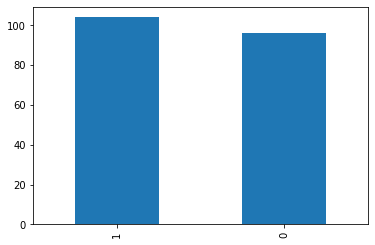

In [127]:
hist = train_eval['label'].value_counts().plot(kind='bar')


Distribution of values in test

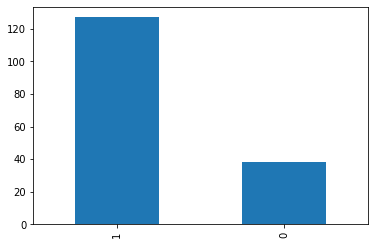

In [129]:
test_eval['label'].value_counts().plot(kind='bar')

## Creating the mask 
As stated earlier however GAD uses masking so we might want masks.